<a href="https://colab.research.google.com/github/nati-curious/data-science-epam-course/blob/main/classification_Sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Multiclass classification (thyroid diagnosis) with Logistic regression and KNN**

# Frameworks and libraries

In [ ]:
# Install a package for imputation
!pip install miceforest --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 179.8 MB/s eta 0:00:00


*Imputation by Chained Equation (MICE) with LightGBM.\
Chained equations imputation is widely used in medical research.*

*Multiple Imputation iteratively 'fills in' missing values in a dataset by modeling each variable as a function of the other variables. The function used in this package is random forests, because they have advantages which work well with the multiple imputation algorithm. For detailed information, see https://github.com/AnotherSamWilson/miceforest*

In [ ]:
import pandas as pd
import numpy as np
import os

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, fbeta_score

import miceforest as mf

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
plt.style.use('ggplot')
%matplotlib inline

# Helper function

In [ ]:
# Function to evaluate a classification model
def report(y_test, yhat_classes):
    labels = sorted(np.unique(y_test))
    print('\n===F2 scores:===')
    res = fbeta_score(y_test, yhat_classes, beta=2, average=None, labels = labels)
    print(pd.DataFrame({'F2':res}, index = labels))

    print('\n===classification report:===')
    print(classification_report(y_test, yhat_classes))

    print('\n===confusion matrix===')
    sns.heatmap(confusion_matrix(y_test, yhat_classes),
                annot=confusion_matrix(y_test, yhat_classes),
                xticklabels=labels,
                yticklabels=labels);
    plt.xticks(horizontalalignment='right')
    plt.ylabel('True', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)

# EDA and Data Preparation #

In [ ]:
# Upload the data set
df = pd.read_csv('/content/drive/MyDrive/dataset_57_hypothyroid.csv')
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,f,?,other,negative
3768,68,F,f,f,f,f,f,f,f,f,...,t,124,t,1.08,t,114,f,?,SVI,negative
3769,74,F,f,f,f,f,f,f,f,f,...,t,112,t,1.07,t,105,f,?,other,negative
3770,72,M,f,f,f,f,f,f,f,f,...,t,82,t,0.94,t,87,f,?,SVI,negative


In [ ]:
# Remove duplicates if any
df = df.drop_duplicates(ignore_index=True)
df.shape

(3711, 30)

There were 61 duplicate rows.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3711 entries, 0 to 3710
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3711 non-null   object
 1   sex                        3711 non-null   object
 2   on_thyroxine               3711 non-null   object
 3   query_on_thyroxine         3711 non-null   object
 4   on_antithyroid_medication  3711 non-null   object
 5   sick                       3711 non-null   object
 6   pregnant                   3711 non-null   object
 7   thyroid_surgery            3711 non-null   object
 8   I131_treatment             3711 non-null   object
 9   query_hypothyroid          3711 non-null   object
 10  query_hyperthyroid         3711 non-null   object
 11  lithium                    3711 non-null   object
 12  goitre                     3711 non-null   object
 13  tumor                      3711 non-null   object
 14  hypopitu

It seems there is no NA values.\
Categorical variable 'age' has a string format - later I'll convert to numerical.\
Numerical features like 'TT4', 'T4U', 'FTI', 'TSH', 'T3' have data type 'object' - later I'll change the data type for numerical.\
Drop:
* 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured' columns as their values just indicates whether or not a medical test was taken,
* referral source doesn't bring too much to the model,
* all the TBG analysis values are missing so we have to delete this column.

In [ ]:
df = df.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', \
              'FTI_measured', 'TBG_measured', 'TBG', 'referral_source'], axis=1)

In [ ]:
# Check for anomalies in values
df.min()

age                                                1
sex                                                ?
on_thyroxine                                       f
query_on_thyroxine                                 f
on_antithyroid_medication                          f
sick                                               f
pregnant                                           f
thyroid_surgery                                    f
I131_treatment                                     f
query_hypothyroid                                  f
query_hyperthyroid                                 f
lithium                                            f
goitre                                             f
tumor                                              f
hypopituitary                                      f
psych                                              f
TSH                                            0.005
T3                                              0.05
TT4                                           

Question marks in 'sex' column tells us that there are missing values.\
0.005 mIU/L for TSH and 0.25 μg/dL for T4U are normal values, they areencountered in patients with endocrine disorder.

In [ ]:
# Check for anomalities
df.max()

age                                              ?
sex                                              M
on_thyroxine                                     t
query_on_thyroxine                               t
on_antithyroid_medication                        t
sick                                             t
pregnant                                         t
thyroid_surgery                                  t
I131_treatment                                   t
query_hypothyroid                                t
query_hyperthyroid                               t
lithium                                          t
goitre                                           t
tumor                                            t
hypopituitary                                    t
psych                                            t
TSH                                              ?
T3                                               ?
TT4                                              ?
T4U                            

Question marks in `age`, `TSH`, `T3`, `TT4`, `T4U`, `FTI` columns tells us that there are missing values.

In [ ]:
# Replace question marks with NaN for further manipulation with those values
df[['age', 'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']] = df[['age', \
    'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']].replace('?', np.NaN)
print(df.isnull().sum())

age                            1
sex                          149
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          309
T3                           709
TT4                          171
T4U                          327
FTI                          325
Class                          0
dtype: int64


In [ ]:
# Drop the rows with all NaN values if any
df.dropna(how='all')
df.shape

(3711, 22)

There is no rows with all NaN values.

Categorical variables: `sex`, `on_thyroxine`, `query_on_thyroxine`, `on_antithyroid_medication`, `sick`, `pregnant`, `thyroid_surgery`, `I131_treatment`, `query_hypothyroid`, `query_hyperthyroid`, `lithium`, `goitre`, `tumor`, `hypopituitary`, `psych`, and `Class`.

Numerical variable: `age`, `TSH`, `T3`, `TT4`, `T4U`, `FTI`.

In [ ]:
# Convert data type of numerical values to float
df[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']] = df[['age', 'TSH', 'T3', 'TT4', \
                                                    'T4U', 'FTI']].astype(float)

In [ ]:
# Check if the columns are prompted with the type that it is supposed to be
df.dtypes

age                          float64
sex                           object
on_thyroxine                  object
query_on_thyroxine            object
on_antithyroid_medication     object
sick                          object
pregnant                      object
thyroid_surgery               object
I131_treatment                object
query_hypothyroid             object
query_hyperthyroid            object
lithium                       object
goitre                        object
tumor                         object
hypopituitary                 object
psych                         object
TSH                          float64
T3                           float64
TT4                          float64
T4U                          float64
FTI                          float64
Class                         object
dtype: object

In [ ]:
# Check for missing values
df.isnull().sum()

age                            1
sex                          149
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          309
T3                           709
TT4                          171
T4U                          327
FTI                          325
Class                          0
dtype: int64

In [ ]:
# Check for anomalies
df['age'].value_counts()

59.0     95
60.0     90
70.0     88
73.0     81
55.0     79
         ..
10.0      1
4.0       1
5.0       1
455.0     1
6.0       1
Name: age, Length: 93, dtype: int64

455 is unreal human age. Probably the error is double 5. Let's replace 455 with 45.

In [ ]:
# Replace 455 with 45
df['age'] = df['age'].replace(455.0, 45.0)

In [ ]:
# Check for anomalies and value balance
df['sex'].value_counts()

F    2424
M    1138
Name: sex, dtype: int64

In [ ]:
df['on_thyroxine'].value_counts()

f    3247
t     464
Name: on_thyroxine, dtype: int64

In [ ]:
df['query_on_thyroxine'].value_counts()

f    3661
t      50
Name: query_on_thyroxine, dtype: int64

In [ ]:
df['on_antithyroid_medication'].value_counts()

f    3669
t      42
Name: on_antithyroid_medication, dtype: int64

In [ ]:
df['sick'].value_counts()

f    3564
t     147
Name: sick, dtype: int64

In [ ]:
df['pregnant'].value_counts()

f    3658
t      53
Name: pregnant, dtype: int64

In [ ]:
df['thyroid_surgery'].value_counts()

f    3658
t      53
Name: thyroid_surgery, dtype: int64

In [ ]:
df['I131_treatment'].value_counts()

f    3652
t      59
Name: I131_treatment, dtype: int64

In [ ]:
df['query_hypothyroid'].value_counts()

f    3477
t     234
Name: query_hypothyroid, dtype: int64

In [ ]:
df['query_hyperthyroid'].value_counts()

f    3477
t     234
Name: query_hyperthyroid, dtype: int64

In [ ]:
df['lithium'].value_counts()

f    3693
t      18
Name: lithium, dtype: int64

In [ ]:
df['goitre'].value_counts()

f    3677
t      34
Name: goitre, dtype: int64

In [ ]:
df['tumor'].value_counts()

f    3615
t      96
Name: tumor, dtype: int64

In [ ]:
df['hypopituitary'].value_counts()

f    3710
t       1
Name: hypopituitary, dtype: int64

Let's drop `hypopituitary` column because it's only one true and all others are 'false' it doesn't bring much to the model.

In [ ]:
df = df.drop(['hypopituitary'], axis=1)

In [ ]:
df['psych'].value_counts()

f    3527
t     184
Name: psych, dtype: int64

In [ ]:
df['Class'].value_counts()

negative                   3420
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

In [ ]:
# Percentage of 'secondary_hypothyroid' class
2/3711

0.0005389382915656157

A target variable is highly imbalanced. `secondary_hypothyroid` is represented by 2 samples (0.05% of total number of samples in a variable). We could oversample this class with SMOTE in case it was at least 3% of total samples; hence, it's reasonable to drop it.

In [ ]:
df.drop(df[df.Class == 'secondary_hypothyroid'].index, inplace = True)

## Multivariate analysis

### Feature correlation

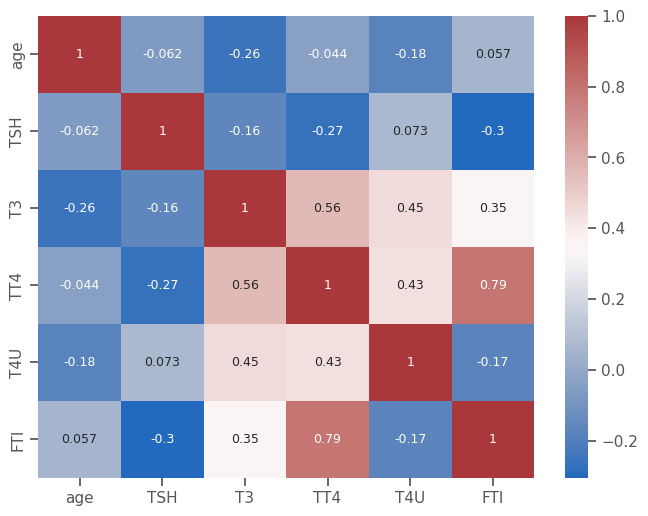

In [ ]:
# Plot heatmap
corr = df.corr()
sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
sns.heatmap(corr, annot=True, annot_kws={"size": 9}, cmap="vlag");

### Pairwise correlation

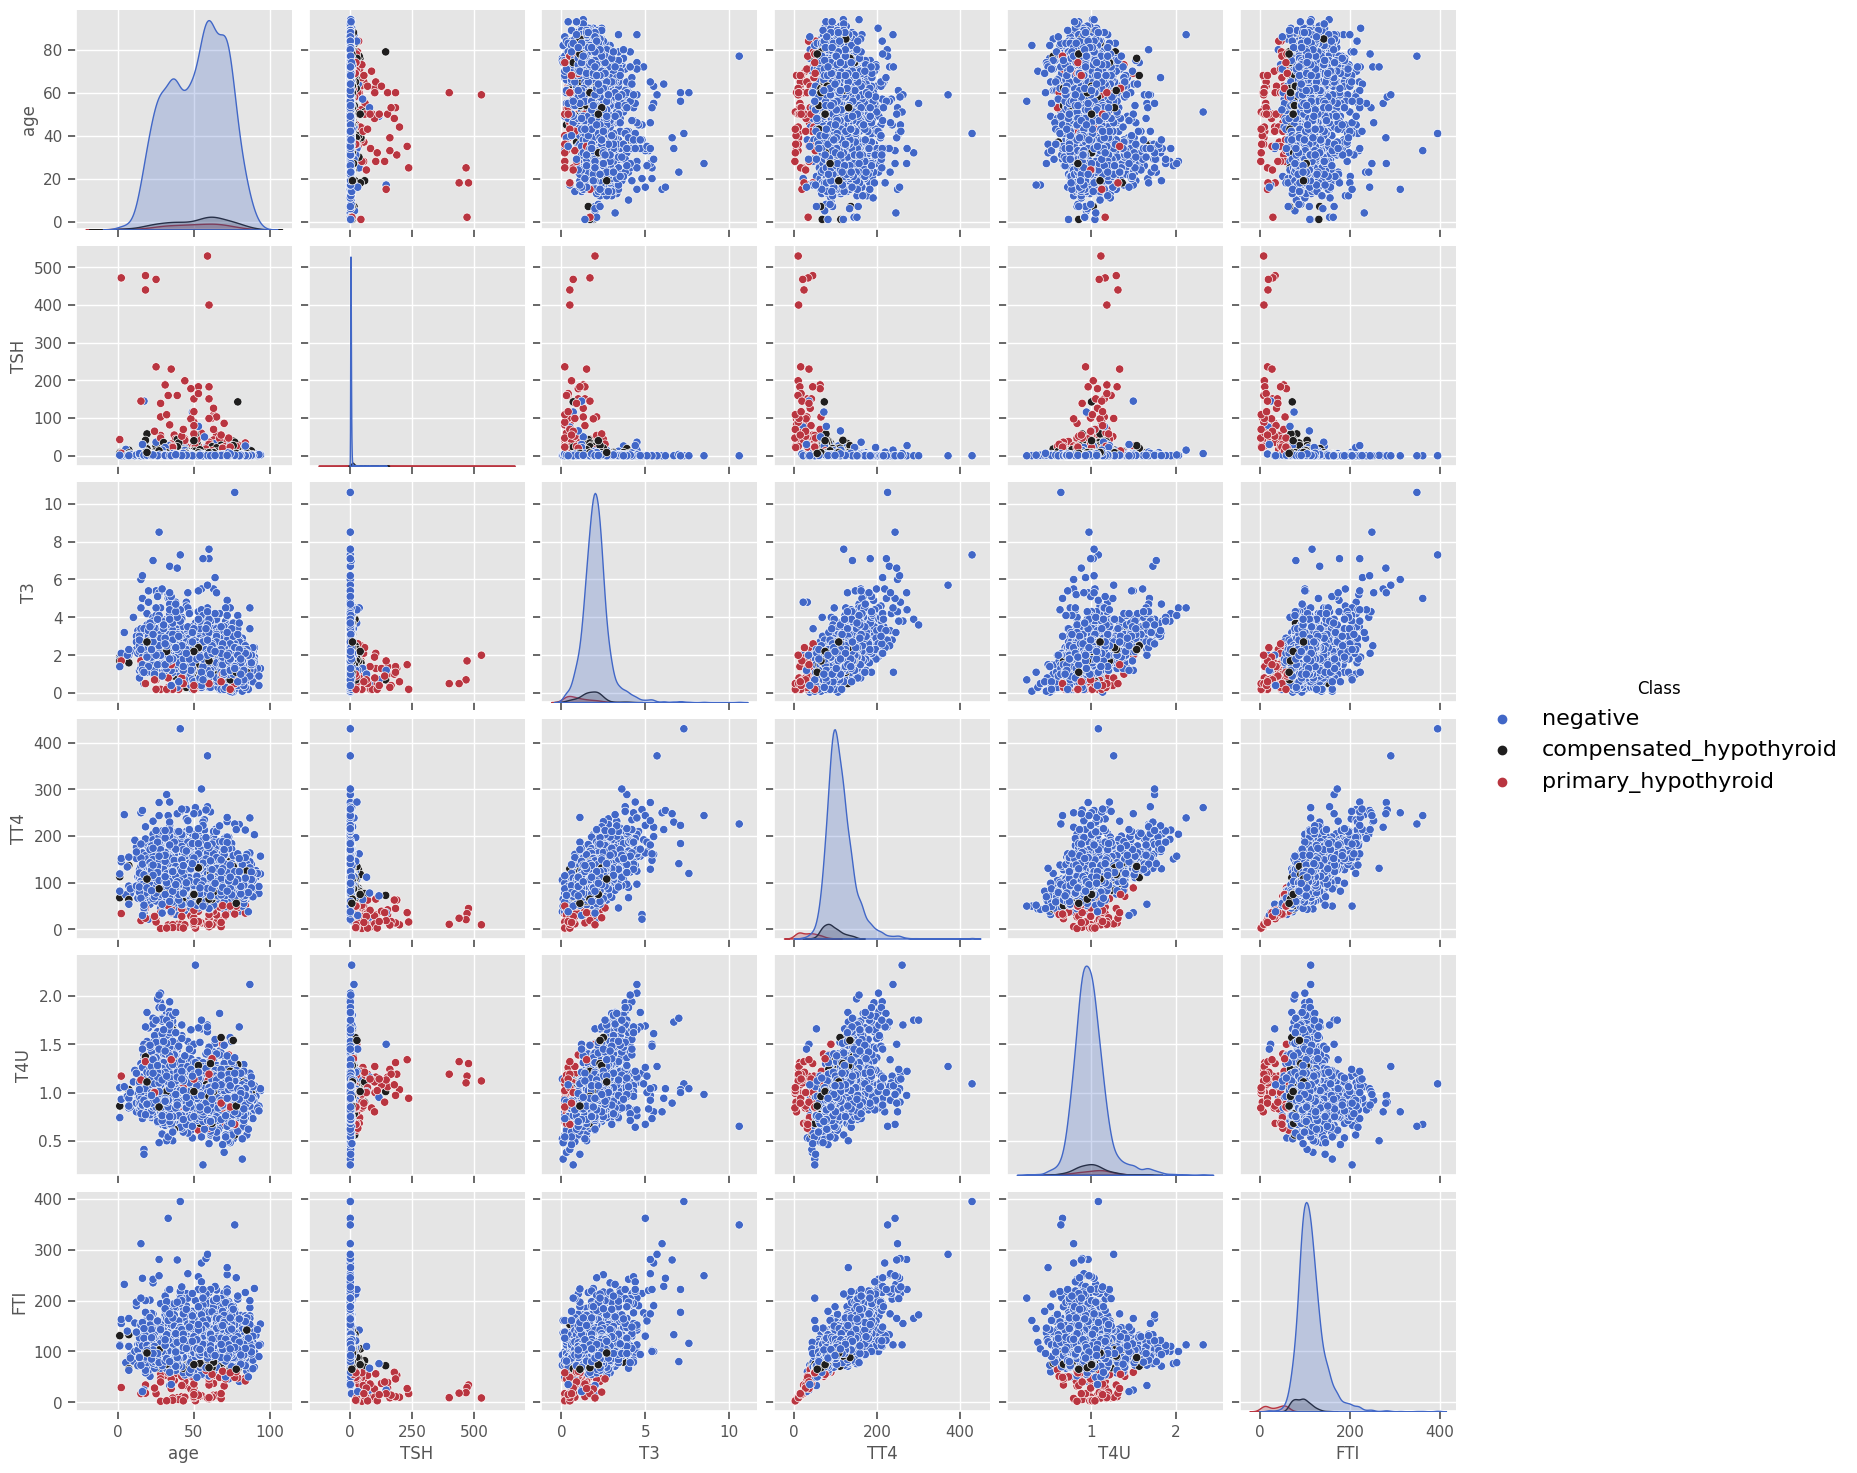

In [ ]:
plt.rc('legend', fontsize=16)
sns.pairplot(df, hue='Class', palette='icefire');

## Train/test split and X/y split

In [ ]:
# Input/output split
X, y = df.drop('Class', axis=1), df['Class']

In [ ]:
# Train/test split (stratify=y to get each out of 3 classes in split data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2967, 20), (742, 20), (2967,), (742,))

In [ ]:
# Encode target variable that has 4 classes with Label Encoder
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

## Scaling and filling NAs

In [ ]:
cat_features = df.select_dtypes(object).columns
list(cat_features)

['sex',
 'on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_medication',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'psych',
 'Class']

In [ ]:
num_features = df.select_dtypes(float).columns
list(num_features)

['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

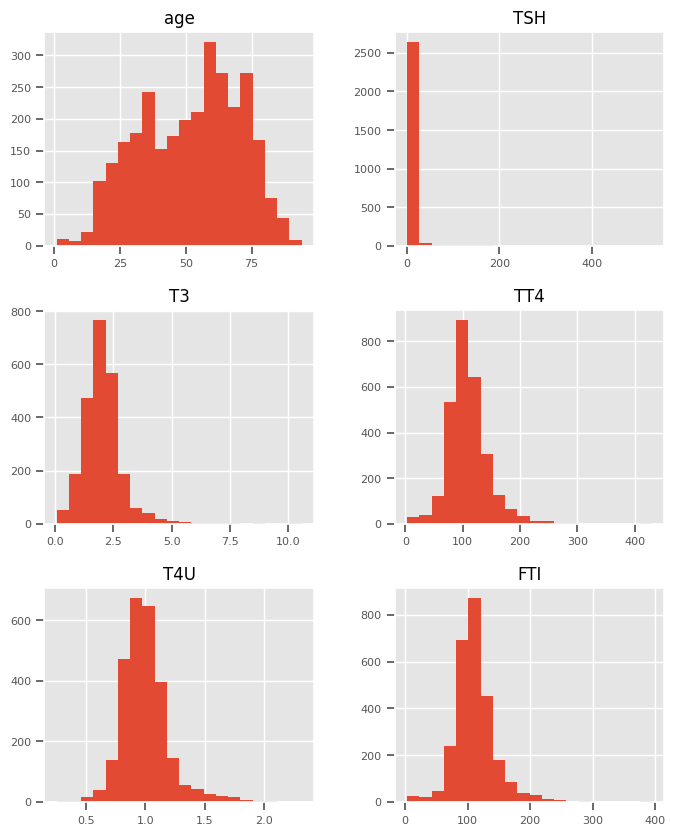

In [ ]:
# Check distribution to decide what kind of scaling to use
X_train[num_features].hist(figsize=(8, 10), bins=20, xlabelsize=8, ylabelsize=8);

`TSH` has skewed distribution,\
`age` - binomial,\
other variables - normal, exept for `TT4` and `TT4U` - normal with a slight skeweness.\
Let's use Robust Scaler that is robust to outliers.

In [ ]:
# Normalize numerical variables
robust_scaler = RobustScaler()

X_train[num_features] = robust_scaler.fit_transform(X_train[num_features])
X_test[num_features] = robust_scaler.transform(X_test[num_features])

In [ ]:
# Impute NAs in numerical variables of a train subset
X_train[num_features] = mf.ampute_data(
    X_train[num_features],
    perc=0.25,
    random_state=7)

kds = mf.ImputationKernel(
    X_train[num_features],
    save_all_iterations=True,
    random_state=7
)

kds.mice(2)

X_train_num = kds.complete_data()


# Impute NAs in numerical variables of a test subset
X_test[num_features] = mf.ampute_data(
    X_test[num_features],
    perc=0.25,
    random_state=7)

kds = mf.ImputationKernel(
    X_test[num_features],
    save_all_iterations=True,
    random_state=7
)

kds.mice(2)

X_test_num = kds.complete_data()

In [ ]:
# Exclude a target variable since we already encoded it into labels
cat_features = cat_features.drop('Class')

In [ ]:
# Encode categroical variables
enc = OrdinalEncoder()

X_train[cat_features] = enc.fit_transform(X_train[cat_features])
X_test[cat_features] = enc.transform(X_test[cat_features])

In [ ]:
# Impute NAs in categorical variables
X_train[cat_features] = X_train[cat_features].astype('category')
X_train[cat_features] = mf.ampute_data(X_train[cat_features], perc=0.04, random_state=7)

kds = mf.ImputationKernel(
    X_train[cat_features],
    save_all_iterations=True,
    random_state=7
)

kds.mice(2)

X_train_cat = kds.complete_data()


X_test[cat_features] = X_test[cat_features].astype('category')
X_test[cat_features] = mf.ampute_data(X_test[cat_features], perc=0.04, random_state=7)

kds = mf.ImputationKernel(
    X_test[cat_features],
    save_all_iterations=True,
    random_state=7
)

kds.mice(2)

X_test_cat = kds.complete_data()

In [ ]:
# Concatenate columns with numerical and categorical features
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

# Logistic Regression

## Baseline


===F2 scores:===
         F2
0  0.632653
1  0.922734
2  0.800000

===classification report:===
              precision    recall  f1-score   support

           0       0.35      0.79      0.48        39
           1       0.99      0.91      0.95       684
           2       0.67      0.84      0.74        19

    accuracy                           0.90       742
   macro avg       0.67      0.85      0.72       742
weighted avg       0.95      0.90      0.92       742


===confusion matrix===


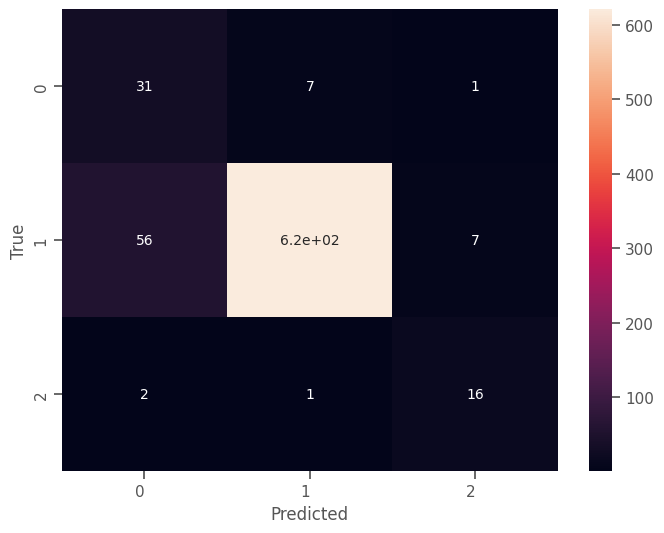

In [ ]:
logreg = LogisticRegression(class_weight='balanced', multi_class='multinomial')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
report(y_test, y_pred)

Evaluating classification of unbalanced medical data it is important to catch all positive that's why we want to maximize recall.

In addition to recall let's pay attention to the F2 score was chosen over F1 because F2 is the weighted harmonic mean of the precision and recall (given a threshold value). Unlike the F1 score, which gives equal weight to precision and recall, the F2 score gives more weight to recall than to precision.

## Hyperparameter tuning

In [ ]:
f2_score = make_scorer(fbeta_score, beta=2, average='weighted')
logreg_gs = GridSearchCV(estimator = LogisticRegression(multi_class='multinomial'),
                         param_grid = {'penalty': ['l1','l2'],
                                       'C':[1e-3, 1e-2, 1e-1, 1e+0, 1e+1],
                                       'class_weight':['balanced']},
                         scoring=f2_score, cv = StratifiedKFold(n_splits=3))
logreg_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2']},
             scoring=make_scorer(fbeta_score, beta=2, average=weighted))

In [ ]:
logreg_gs.best_estimator_.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=0.001, class_weight='balanced', multi_class='multinomial')>


===F2 scores:===
         F2
0  0.666667
1  0.951608
2  0.781250

===classification report:===
              precision    recall  f1-score   support

           0       0.43      0.77      0.56        39
           1       0.99      0.94      0.96       684
           2       0.75      0.79      0.77        19

    accuracy                           0.93       742
   macro avg       0.72      0.83      0.76       742
weighted avg       0.95      0.93      0.94       742


===confusion matrix===


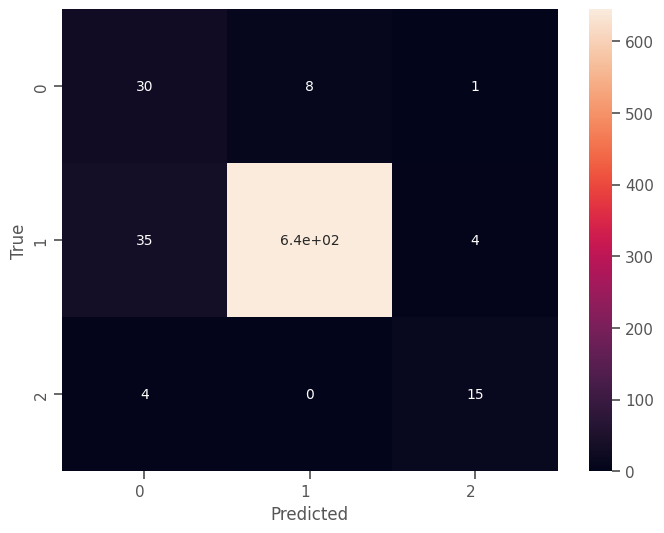

In [ ]:
y_pred = logreg_gs.best_estimator_.predict(X_test)
report(y_test, y_pred)

## Feature importance

In [ ]:
sorted(np.unique(y_train))

[0, 1, 2]

Keep in mind `negative` is labelled as 1, `compensated_hypothyroid` as 0, `primary_hypothyroid` as 2.

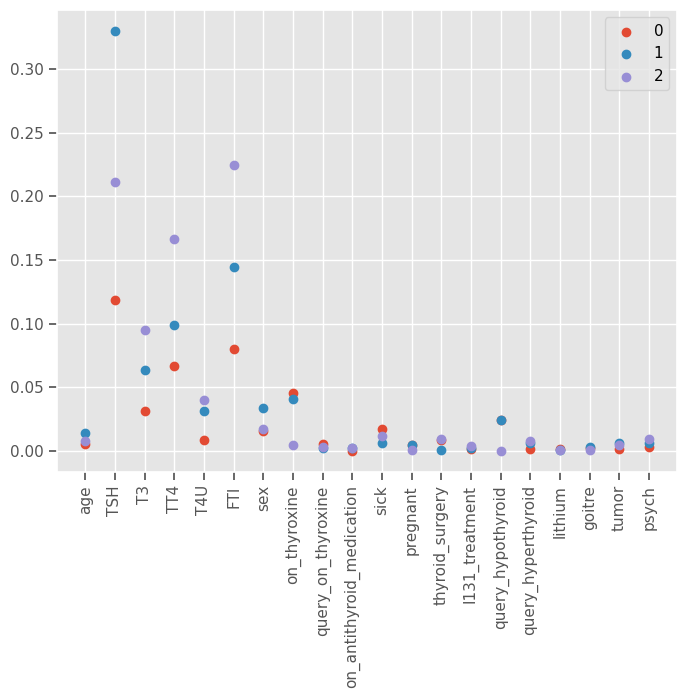

In [ ]:
plt.scatter(x = list(X_train.columns), y = np.abs(logreg_gs.best_estimator_.coef_[0]), label = 0)
plt.scatter(x = list(X_train.columns), y = np.abs(logreg_gs.best_estimator_.coef_[1]), label = 1)
plt.scatter(x = list(X_train.columns), y = np.abs(logreg_gs.best_estimator_.coef_[2]), label = 2)
plt.xticks(rotation=90)
plt.legend();

In [ ]:
# Remove features that have low importance
X_train = X_train.drop(['on_antithyroid_medication', 'I131_treatment', 'lithium', \
                        'goitre', 'query_on_thyroxine', 'pregnant', 'tumor', 'psych'], axis=1)
X_test = X_test.drop(['on_antithyroid_medication', 'I131_treatment', 'lithium', \
                      'goitre', 'query_on_thyroxine', 'pregnant', 'tumor', 'psych'], axis=1)


===F2 scores:===
         F2
0  0.614754
1  0.921522
2  0.784314

===classification report:===
              precision    recall  f1-score   support

           0       0.34      0.77      0.47        39
           1       0.99      0.91      0.95       684
           2       0.62      0.84      0.71        19

    accuracy                           0.90       742
   macro avg       0.65      0.84      0.71       742
weighted avg       0.94      0.90      0.91       742


===confusion matrix===


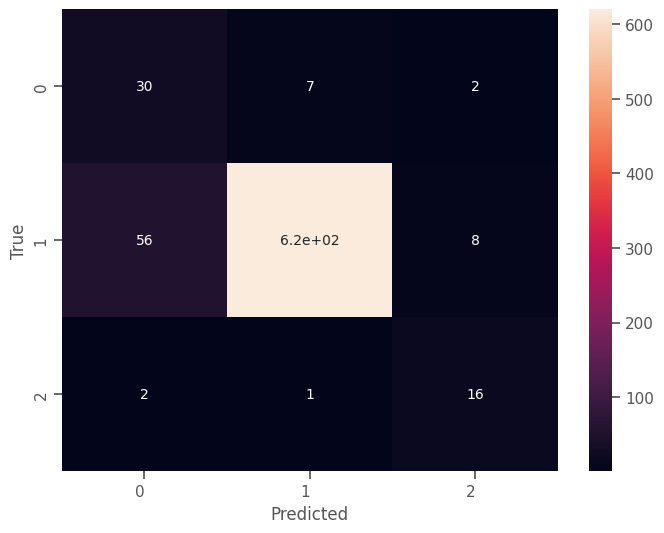

In [ ]:
logreg2 = LogisticRegression(class_weight='balanced', multi_class='multinomial')
logreg2.fit(X_train,y_train)
y_pred = logreg2.predict(X_test)
report(y_test, y_pred)

In [ ]:
f2_score = make_scorer(fbeta_score, beta=2, average='weighted')
logreg_gs2 = GridSearchCV(estimator = LogisticRegression(multi_class='multinomial'),
                         param_grid = {'penalty': ['l1','l2'],
                                       'C':[1e-3, 1e-2, 1e-1, 1e+0, 1e+1],
                                       'class_weight':['balanced']},
                         scoring=f2_score, cv = StratifiedKFold(n_splits=5))
logreg_gs2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2']},
             scoring=make_scorer(fbeta_score, beta=2, average=weighted))

In [ ]:
logreg_gs2.best_estimator_.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=0.001, class_weight='balanced', multi_class='multinomial')>


===F2 scores:===
         F2
0  0.666667
1  0.951608
2  0.781250

===classification report:===
              precision    recall  f1-score   support

           0       0.43      0.77      0.56        39
           1       0.99      0.94      0.96       684
           2       0.75      0.79      0.77        19

    accuracy                           0.93       742
   macro avg       0.72      0.83      0.76       742
weighted avg       0.95      0.93      0.94       742


===confusion matrix===


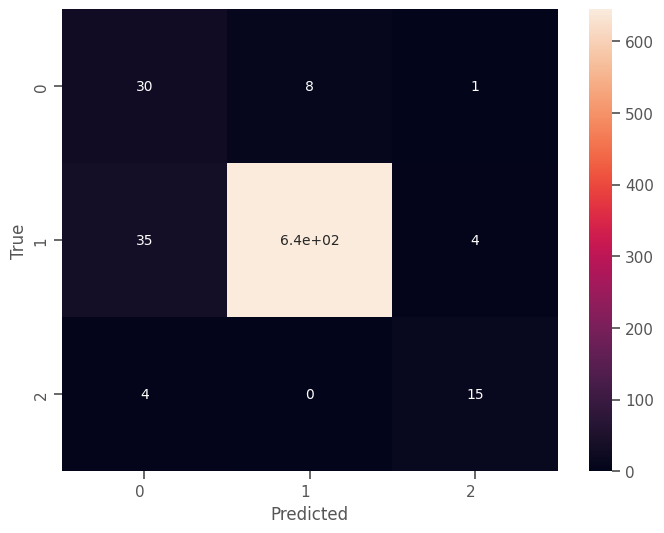

In [ ]:
y_pred = logreg_gs2.best_estimator_.predict(X_test)
report(y_test, y_pred)

# KNN


===F2 scores:===
         F2
0  0.502646
1  0.976676
2  0.659341

===classification report:===
              precision    recall  f1-score   support

           0       0.58      0.49      0.53        39
           1       0.97      0.98      0.97       684
           2       0.80      0.63      0.71        19

    accuracy                           0.94       742
   macro avg       0.78      0.70      0.74       742
weighted avg       0.94      0.94      0.94       742


===confusion matrix===


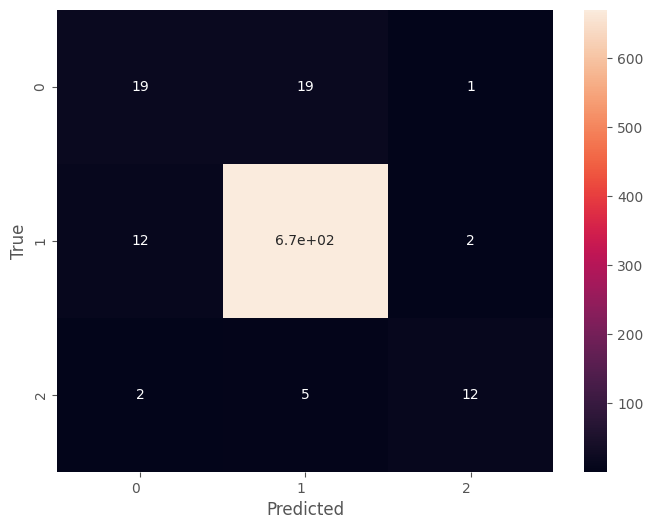

In [ ]:
knn = KNeighborsClassifier(weights='distance', n_jobs= -1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
report(y_test, y_pred)

## Hyperparameter tuning

In [ ]:
# Define parameters for GridSearch
grid_params = {'n_neighbors' : [3, 4, 9],
               'weights' : ['distance'],
               'metric' : ['manhattan']}

In [ ]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=1, cv=3, n_jobs=-1)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan'], 'n_neighbors': [3, 4, 9],
                         'weights': ['distance']},
             verbose=1)

In [ ]:
# Print the best score and the best parameters to get it
print(gs.best_score_)
print(gs.best_params_)

0.9379844961240309
{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


In [ ]:
# Use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors=4, weights='distance',
                           metric='manhattan',
                           n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=4,
                     weights='distance')


===F2 scores:===
         F2
0  0.507614
1  0.974007
2  0.617978

===classification report:===
              precision    recall  f1-score   support

           0       0.49      0.51      0.50        39
           1       0.97      0.98      0.97       684
           2       0.85      0.58      0.69        19

    accuracy                           0.94       742
   macro avg       0.77      0.69      0.72       742
weighted avg       0.94      0.94      0.94       742


===confusion matrix===


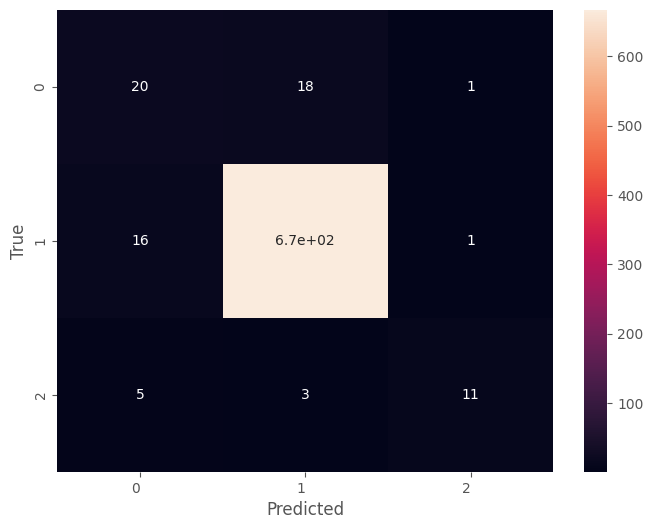

In [ ]:
y_pred = knn.predict(X_test)
report(y_test, y_pred)

# Conclusion

Logistic Regression model showed much more better result than KNN model (hyperparameter tuning didn't help to improve the model).